In [4]:
#Задание Юдина Евгения Викторовича, которая заключалась в том, чтобы 
#реализовать модуль по производительности вертикальной скважины в круговом 
#пласте с использованием преобразования Лапласа на неустаноивиешмся режиме 
#с заданными условиями на внешней границе и на скважине
#В задаче 2 пласта с условием отст=утствия перетока на внешней границе и постоянного давления на забое
import sympy as sp
from sympy.utilities.lambdify import implemented_function
import scipy as sci
import math
import numpy as np
import mpmath as mp
import anaflow
import matplotlib.pyplot as plt

#коэффициенты
rw = 0.108
re1 = 400
re2 = 500
pw = 50
mu = 5e-3
c_total=20e-9
h = 50
k = 9e-12
pe = 350
phi=0.15
kappa = k/(phi*mu*c_total)


s = sp.symbols('s', real = True, positive= True)

# Функции Бесселя для будущей подстановки в уравнения
I0rw = sp.functions.special.bessel.besseli(0, ((s)/kappa)**(1/2)*rw)
I1rw = sp.functions.special.bessel.besseli(1, ((s)/kappa)**(1/2)*rw)
I1re1 = sp.functions.special.bessel.besseli(1, ((s)/kappa)**(1/2)*re1)
I1re2 = sp.functions.special.bessel.besseli(1, ((s)/kappa)**(1/2)*re2)


K0rw = sp.functions.special.bessel.besselk(0, ((s)/kappa)**(1/2)*rw)
K1rw = sp.functions.special.bessel.besselk(1, ((s)/kappa)**(1/2)*rw)
K1re1 = sp.functions.special.bessel.besselk(1, ((s)/kappa)**(1/2)*re1)
K1re2 = sp.functions.special.bessel.besselk(1, ((s)/kappa)**(1/2)*re2)


C1, C2, C3, C4 = sp.symbols('C1, C2, C3, C4')

#Уравнения, получившиеся в результате решения соответствующих уравнений пьезопроводности с граничными условиями
eq1 = (C1 * I0rw + C2 * K0rw - (pw - pe)/s)
eq2 = (C3 * I0rw + C4 * K0rw - (pw - pe)/s)
eq3 = (s/kappa)**(1/2) * (C1 * I1re1 - C2 * K1re1)
eq4 = (s/kappa)**(1/2) * (C3 * I1re2 - C4 * K1re2)

#Решаем систему
solve = sp.solve([eq1, eq2, eq3, eq4], [C1,C2,C3,C4], dict=True)

r = sp.symbols('r', real = True, positive= True)

I0 = sp.functions.special.bessel.besseli(0, ((s)/kappa)**(1/2) *r)
K0 = sp.functions.special.bessel.besselk(0, ((s)/kappa)**(1/2) *r)
#Выражения для давлений
plap1 = solve[0].get(C1) * I0 + solve[0].get(C2) * K0
plap2 = solve[0].get(C3) * I0 + solve[0].get(C4) * K0
#Выражения для дебитов
qlap1 = 2*3.14*k*h*rw/(mu) *(s/kappa)**(1/2)* ( solve[0].get(C1)*I1rw - solve[0].get(C2)*K1rw )
qlap2 = 2*3.14*k*h*rw/(mu)*(s/kappa)**(1/2) * ( solve[0].get(C3)*I1rw - solve[0].get(C4)*K1rw )
qlap = qlap1 + qlap2


In [6]:
#Чтобы пользоваться как обычными функциями
plap_standart1 = sp.lambdify([s,r], plap1)
plap_standart2 = sp.lambdify([s,r], plap2)
qlap_standart = sp.lambdify([s], qlap)

In [7]:
#обратные преобразования Лапласа
def P_ilt1(r,t):
    p1 = anaflow.get_lap_inv(plap_standart1, r=r)
    return p1(t) + pe
def P_ilt2(r,t):
    p2 = anaflow.get_lap_inv(plap_standart2, r=r)
    return p2(t) + pe

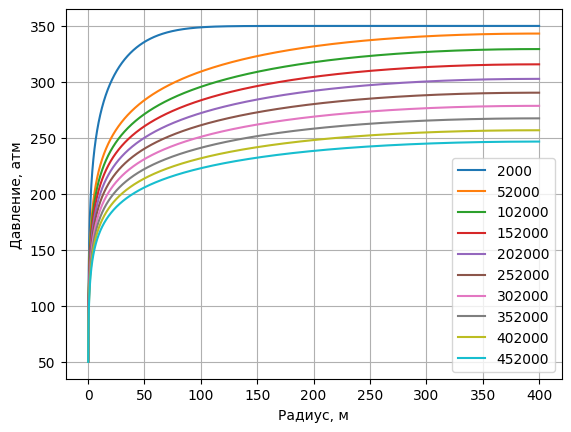

In [8]:
#Графики профилей давлений
t_period = np.arange(2000,500000,50000)
rd_arr = np.arange(rw,re1,0.02)

for ti in t_period:
    plt.plot(rd_arr, np.squeeze( [P_ilt1(ri, ti) for ri in rd_arr ]),label= ti)
plt.xlabel('Радиус, м')
plt.ylabel('Давление, атм')
plt.legend()

plt.grid()
plt.show()

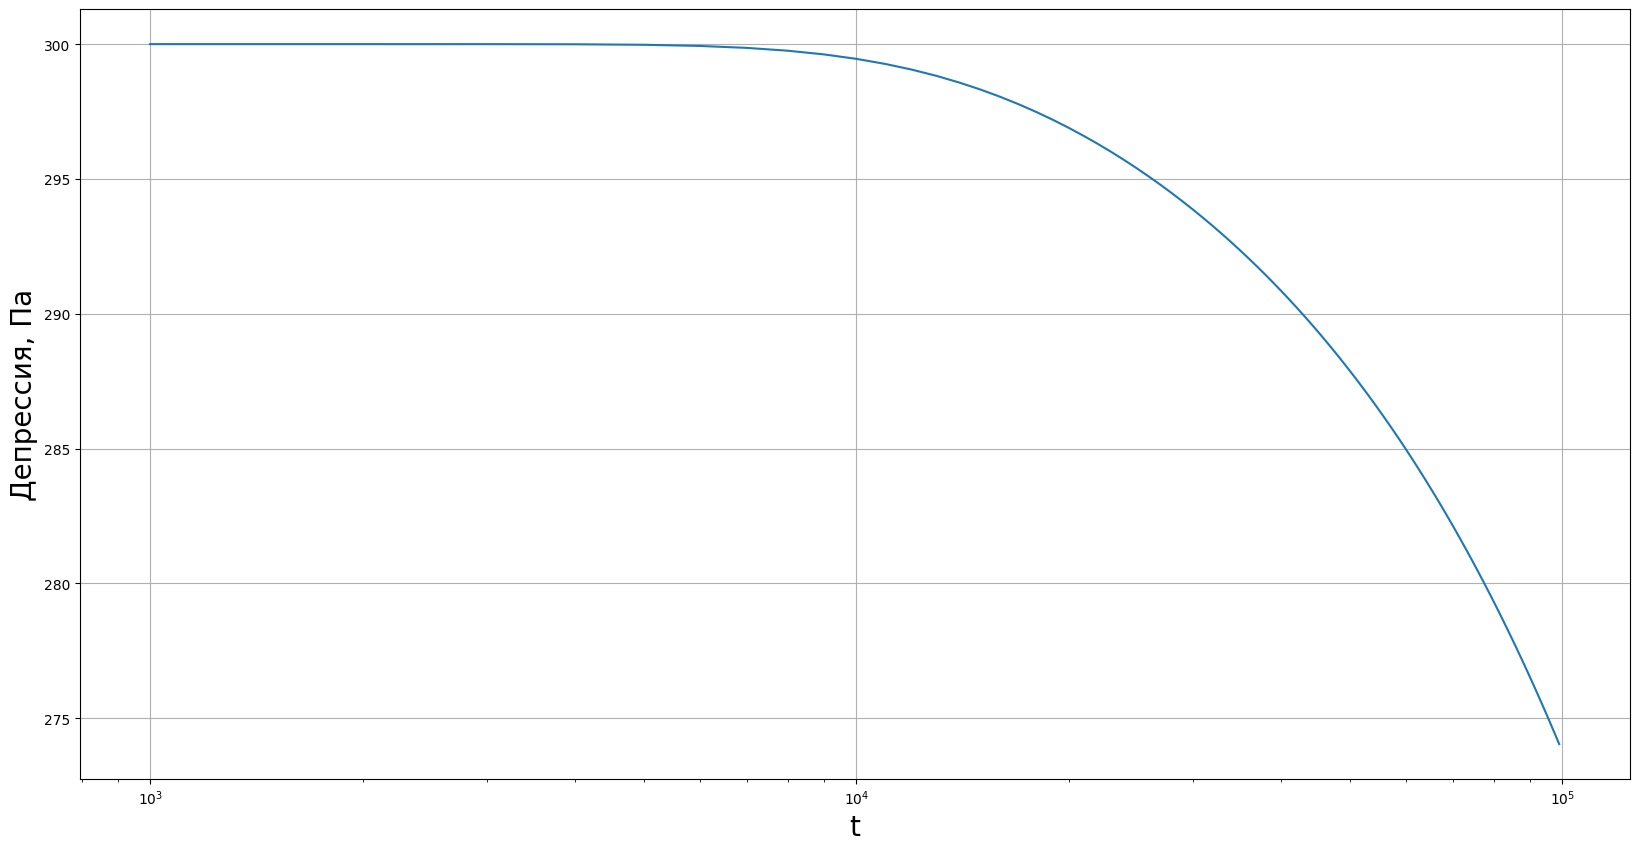

In [9]:
#Депрессия от времени
plt.figure(figsize=[20,10])
t_period2 = np.arange(1000,100000,1000)

plt.semilogx(t_period2, P_ilt1(250, t_period2) - P_ilt1(0.108, t_period2))
plt.xlabel('t',fontsize=20)
plt.ylabel('Депрессия, Па',fontsize=20)
plt.grid()

plt.show()

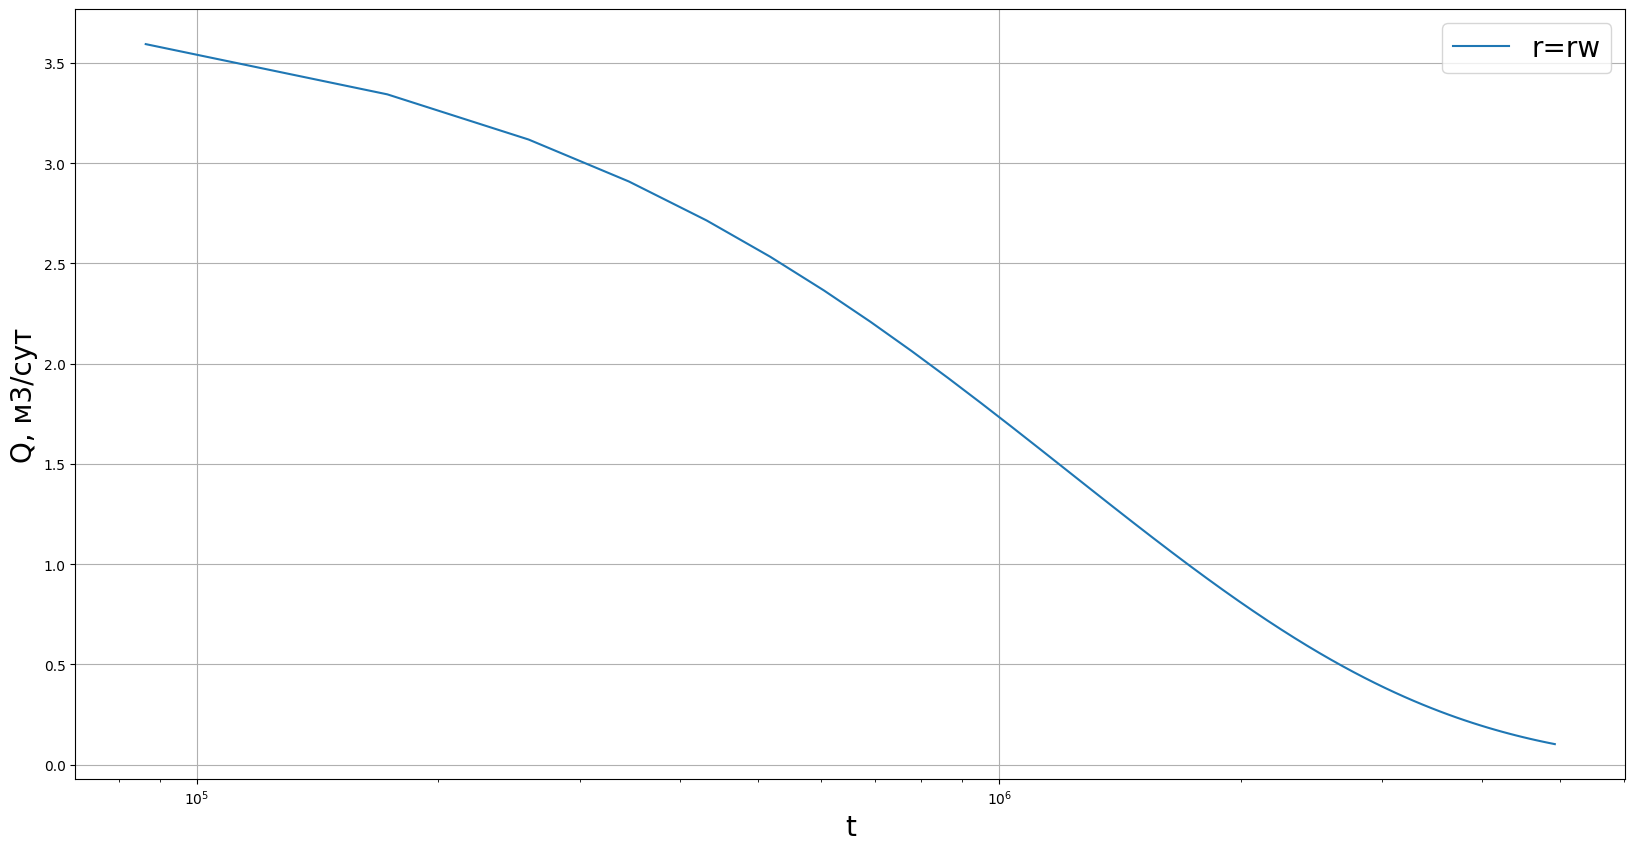

In [10]:
#Дебит от времени
def laplace_inv_Q(t):
    sol_lap_Q = anaflow.get_lap_inv(qlap_standart)
    return sol_lap_Q(t)*86400

t_period2 = np.arange(3600*24,5e6,3600*24)
plt.figure(figsize=[20,10])

plt.semilogx(t_period2, laplace_inv_Q(t_period2), label="r=rw")
plt.xlabel('t',fontsize=20)
#plt.ylim(0,q*86400+5)

plt.ylabel('Q, м3/сут',fontsize=20)
plt.legend(fontsize=20)
plt.grid()
plt.show()
